Анализируем продажи компьютерных игр из стрима. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Не важно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

# 1. Открываем файл

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st


df = pd.read_csv("/datasets/games.csv")

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


# Подготовка данных

In [2]:
#приводим названия столбцов к нижнему регистру
lowerd = {i : i.lower() for i in df.columns}
df = df.rename(columns=lowerd)

In [3]:
#смотрим пропуски
print(df[df['name'].isnull()]) # непонятные 2 значения. можно удалить
df = df[df['name'].notnull()]

      name platform  year_of_release genre  na_sales  eu_sales  jp_sales  \
659    NaN      GEN           1993.0   NaN      1.78      0.53      0.00   
14244  NaN      GEN           1993.0   NaN      0.00      0.00      0.03   

       other_sales  critic_score user_score rating  
659           0.08           NaN        NaN    NaN  
14244         0.00           NaN        NaN    NaN  


In [4]:
# рассмотрим пропуски в дате выпуска
#print(df[df['year_of_release'].isnull()].head(20)) #видим что иногда в "name" есть ответ с годом выпуска
# они идут как последние 4 значения в таких случаях
def find_year(col):
    name = col['name']
    current = name[-4:]
    try:
        if (int(current) >= 1980) &(int(current) <= 2016):
            #print(int(current))
            return int(current)
    except:
        return np.nan
df['find_year']= df.apply(find_year, axis=1)

In [5]:
#print(df[(df['year_of_release'].isnull())&(df['find_year'].notnull())]) #немного удалось найти
df['year_of_release'][df['year_of_release'].isnull()] = df['find_year'][df['year_of_release'].isnull()]
df = df.drop(columns = "find_year")
df.info() # нашли 15 штук всего :(

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16459 non-null float64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 2.2+ MB


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [6]:
pivot = pd.pivot_table(df, index ='platform', values = 'year_of_release', aggfunc = 'mean' )
# будем заполнять оставшиеся пропуски по платформе
platform_years = {pivot.index[i] : pivot['year_of_release'][i] for i in range(len(pivot.index))}
# сохраним медианы в словарик

In [7]:
df['year_of_release'] =df['year_of_release'].fillna("")
def replace_median(col):
    year = col['year_of_release']
    platform =col['platform']
    if year == "":
        #print(year)
        #print(platform_years.get(platform))
        return platform_years.get(platform)
    else:
        return year
#df.info()
df['year_of_release']= df.apply(replace_median, axis=1)
df['year_of_release'] =df['year_of_release'].astype(int)
df.info() 
#с годом выпуска разобрались

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16713 non-null int64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(5), int64(1), object(5)
memory usage: 2.2+ MB


In [8]:
# tbd в рейтингах означает недостаточное количество голосов для оценки
#print(df.query('user_score == "tbd" ')) # 2424 результата

# tbd правильно заменить на Nan. (На 0 нельзя потому что это повалит средние значения.)

def replace_tbd(row):
    user_score = row['user_score']
    if user_score == "tbd":
        return np.nan
    else:
        return user_score
df['user_score']= df.apply(replace_tbd, axis=1)

# заполнятьпропуски в оценках ничем не будем, потому что отсутсвие рейтинга это тоже рейтинг

In [9]:
df['user_score'] = df['user_score'].astype('float')

In [10]:
#Посчитайте суммарные продажи во всех регионах и запишите их в отдельный столбец.

df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] +df['other_sales']

#### Мы подготовили данные к дальнейшему анализу. Заменили дубликаты, создали столбик с сумарным количеством продаж


# Исследовательский анализ данных

AxesSubplot(0.125,0.125;0.775x0.755)


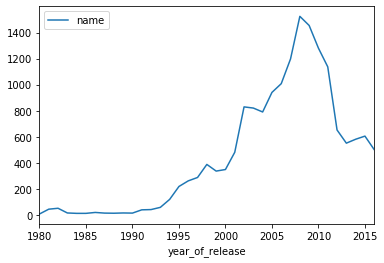

In [11]:
#Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

pivot = df.pivot_table(index = 'year_of_release', values = 'name', aggfunc ='count')
print(pivot.plot())
# с 1998 года идет подьем, еще виден кризис 2008 года 

In [12]:
#Посмотрите, как менялись продажи по платформам. 
#Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам.
#За какой характерный срок появляются новые и исчезают старые платформы?
platforms = pd.pivot_table(df, index = 'platform', values = 'total_sales',
                          aggfunc = 'sum')

platforms = platforms.sort_values('total_sales',ascending = False)
print(platforms)

          total_sales
platform             
PS2           1255.77
X360           971.42
PS3            939.65
Wii            907.51
DS             806.12
PS             730.86
GBA            317.85
PS4            314.14
PSP            294.05
PC             259.52
3DS            259.00
XB             257.74
GB             255.46
NES            251.05
N64            218.68
SNES           200.04
GC             198.93
XOne           159.32
2600            96.98
WiiU            82.19
PSV             54.07
SAT             33.59
GEN             28.35
DC              15.95
SCD              1.86
NG               1.44
WS               1.42
TG16             0.16
3DO              0.10
GG               0.04
PCFX             0.03


In [13]:
#возьмем первые 6, потому что они идут с двукратным отрывом
top6 = platforms.head(6)
top6list = top6.index.tolist()
#теперь построим опять сводную но с годами
platforms_years = pd.pivot_table(df, index = ['platform','year_of_release'], values = 'total_sales',
                          aggfunc = 'sum')

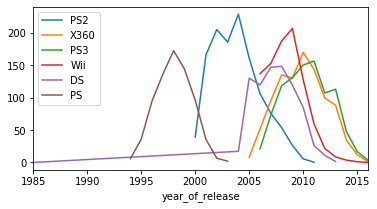

In [14]:
myplot = platforms_years.xs("PS2").plot(figsize = (6,3))
#первый график построим вручную что бы потом нанести на него остальные
top5list = top6list[1:]
for i in top5list:
    #print(i)
    newplot = platforms_years.xs(i).plot(figsize = (6,3), ax = myplot)
    newplot.legend([i for i in top6list])
#мы видим что срок жизни платформы около 10 лет
# пик приходится примерно на 5 лет, после идет спад

In [15]:
#Возьмите данные за соответствующий актуальный период. 
#Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. 
#Основной фактор — эти данные помогут построить прогноз на 2017 год.

#за актуальный преиод возьмем 5 лет, т.к подобное рассмотрение позволит оценить положение
#каждой актуальной платформы и спрогнозировтаь результат

df = df.query('year_of_release  >= 2012')

In [16]:
#Какие платформы лидируют по продажам, растут или падают? 
#Выберите несколько потенциально прибыльных платформ.

actual_platform_years = pd.pivot_table(df, index = ['platform','year_of_release'], values = 'total_sales',
                          aggfunc = 'sum')

print(actual_platform_years)
# всего 11 платформ, выведем их все на график


                          total_sales
platform year_of_release             
3DS      2012                   51.36
         2013                   57.76
         2014                   43.76
         2015                   27.78
         2016                   15.14
DS       2012                   11.01
         2013                    1.54
PC       2012                   23.22
         2013                   12.38
         2014                   13.28
         2015                    8.52
         2016                    5.25
PS3      2012                  107.36
         2013                  113.25
         2014                   47.76
         2015                   16.82
         2016                    3.60
PS4      2013                   25.99
         2014                  100.00
         2015                  118.90
         2016                   69.25
PSP      2012                    7.69
         2013                    3.14
         2014                    0.24
         201

In [17]:
actual_list= actual_platform_years.index.get_level_values('platform').tolist()

In [18]:
#print(actual_list)
actual_list_final = []
for i in actual_list: 
    if i not in actual_list_final: 
        actual_list_final.append(i)     
print(actual_list_final) #убрали дубликаты

['3DS', 'DS', 'PC', 'PS3', 'PS4', 'PSP', 'PSV', 'Wii', 'WiiU', 'X360', 'XOne']


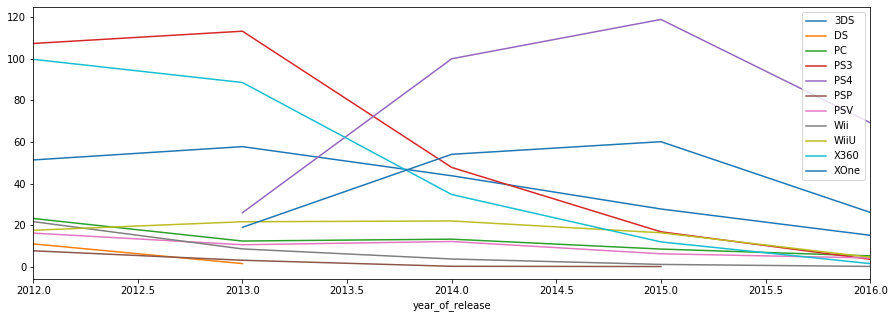

In [19]:
firs_plot = actual_platform_years.xs('3DS').plot(figsize = (15,5))
#первый график построим вручную что бы потом нанести на него остальные
platformlist = actual_list_final[1:]
for i in platformlist:
    #print(i)
    newplot = actual_platform_years.xs(i).plot(figsize = (15,5), ax = firs_plot)
    newplot.legend([i for i in actual_list_final])
    
#везде спад, но платформы PS4 и XOne пока что не окончательно сдохли и будут актуальны в следующем году

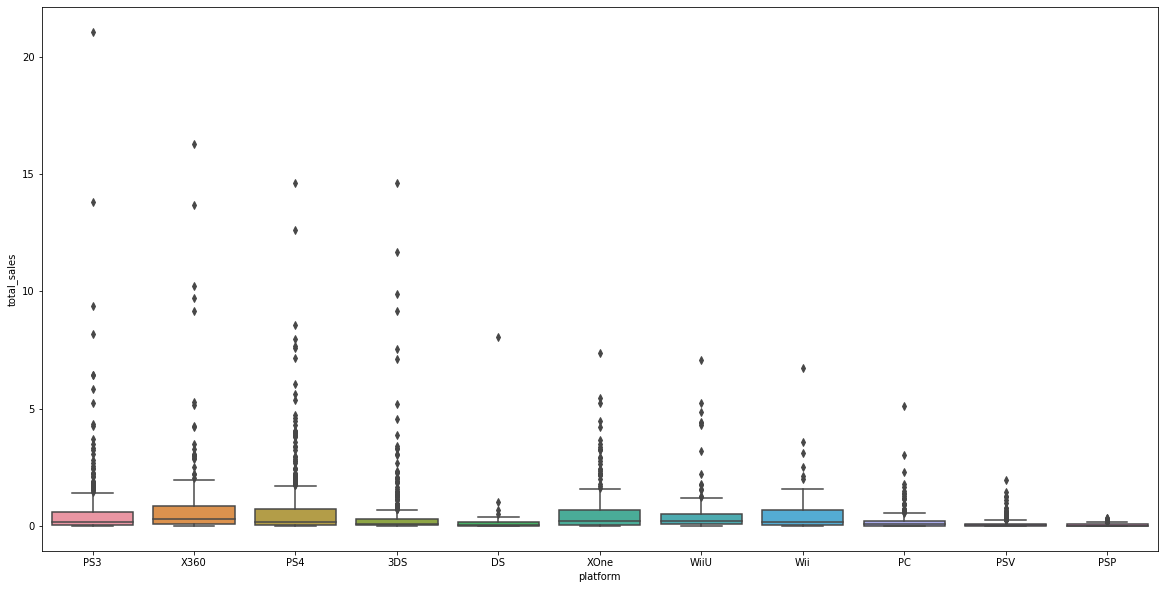

In [20]:
#Постройте график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам. 
#Велика ли разница в продажах? 
#А в средних продажах на разных платформах? Опишите результат.

plt.figure(figsize=(20,10)) #можно нажать на картинку для приближения
sns.boxplot(data = df, y = 'total_sales', x = 'platform')

#у платформ серии XBox (X360, XOne) больше медианная продажа игр, а так же более существенный разброс в большую сторону
#по сравнению с платформами PlayStation (PS3,PS4)
#Платформы WI и WIU по распределению продаж похожи на PS, имеют меньшную медиану и разброс относительно XBoxов


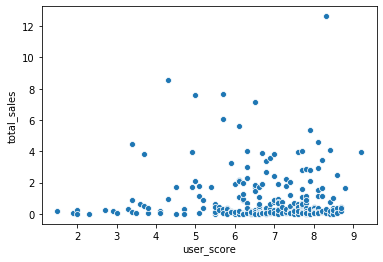

In [21]:
#Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков.
#Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. 
#Сформулируйте выводы.

#возьмем платформу PS4

#по ретйингу игроков
sns.scatterplot(data=df.query('platform == "PS4"').sort_values('user_score'), x = 'user_score', y = 'total_sales')

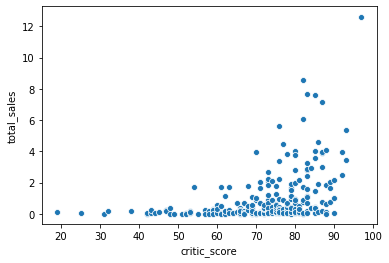

In [22]:
#Критики
sns.scatterplot(data=df.query('platform == "PS4"').sort_values('critic_score'), x = 'critic_score', y = 'total_sales')

In [23]:
#внешне кажется что оценка критиков больше корелирует с продажами, чем оченка игроков.
print(df.query('platform == "PS4"')['critic_score'].corr(df.query('platform == "PS4"')['total_sales']))
print(df.query('platform == "PS4"')['user_score'].corr(df.query('platform == "PS4"')['total_sales']))

#Все правильно. Оценки критиков значимо коррелируют с продажами игры PS4, а оценки самих игроков никак не влияют на продажу

0.40656790206178095
-0.031957110204556424


In [24]:
#Соотнесите выводы с продажами игр на других платформах
print(df['critic_score'].corr(df['total_sales']))
print(df['user_score'].corr(df['total_sales']))
# в целом тенденция примерно такая же, хотя для PS4 рейтинг критиков влияет на продажи все таки чуть больше

0.30829029587247037
0.004817442237192994


In [25]:
#Посмотрите на общее распределение игр по жанрам. 
#Что можно сказать о самых прибыльных жанрах? 
#Выделяются ли жанры с высокими и низкими продажами?

genrepivot = pd.pivot_table(df, index = 'genre', values = 'total_sales', aggfunc = 'mean')
print(genrepivot.sort_values('total_sales'))
#Шутеры в среднем рпиносят значительно больше денег
#в то время как жанры Adventure, Puzzle, Strategy сильно проседают.

              total_sales
genre                    
Adventure        0.097426
Puzzle           0.174643
Strategy         0.187887
Fighting         0.408165
Action           0.427829
Simulation       0.434268
Misc             0.442917
Racing           0.461983
Role-Playing     0.519059
Sports           0.673197
Platform         0.717647
Shooter          1.291525


#### Вывод. Мы провели исследовательский анализ данных. Рассмотрели как исторически менялись продажи игр, установили среднюю продолжительность жизни платформы (около 10 лет). Определили перспективные платформы для продаж игр в будующем году, установили отличие в разбросе дохода игр с PS и XBox. Выяснили что рейтинг критиков существенно влияет на продажи игр, а рейтинг пользователей не влияет совсем. Изучили среднюю доходность по жанрам в результате чего узнали что средний шутер приносит в 14 раз больше дохода чем средняя игра жанра Adventure.

# Портрет пользователя

In [26]:
#Определите для пользователя каждого региона (NA, EU, JP):
#Самые популярные платформы (топ-5). Опишите различия в долях продаж.
#Самые популярные жанры (топ-5). Поясните разницу.

In [27]:
top_platforms_regions = pd.pivot_table(data = df, index = 'platform', values = ['na_sales','eu_sales','jp_sales','total_sales'], aggfunc ='sum' )

print(top_platforms_regions)

          eu_sales  jp_sales  na_sales  total_sales
platform                                           
3DS          42.85     87.84     56.15       195.80
DS            3.53      3.72      4.59        12.55
PC           37.76      0.00     19.12        62.65
PS3         106.86     35.29    103.38       288.79
PS4         141.09     15.96    108.74       314.14
PSP           0.42     10.47      0.13        11.19
PSV          11.41     21.11     11.09        49.44
Wii          11.92      3.39     17.45        35.37
WiiU         25.13     13.01     38.10        82.19
X360         74.52      1.57    140.05       236.54
XOne         51.59      0.34     93.12       159.32


In [28]:
top_platforms_regions['eu_meaning'] = top_platforms_regions['eu_sales'] /(top_platforms_regions['total_sales']/100) 
top_platforms_regions['jp_meaning'] = top_platforms_regions['jp_sales'] /(top_platforms_regions['total_sales']/100) 
top_platforms_regions['na_meaning'] = top_platforms_regions['na_sales'] /(top_platforms_regions['total_sales']/100)
top_platforms_regions[['eu_meaning','jp_meaning','na_meaning']]

,eu_meaning,jp_meaning,na_meaning
platform,,,
3DS,21.884576,44.862104,28.677222
DS,28.127490,29.641434,36.573705
PC,60.271349,0.000000,30.518755
PS3,37.002666,12.219952,35.797638
PS4,44.913096,5.080537,34.615140
PSP,3.753351,93.565684,1.161752
PSV,23.078479,42.698220,22.431230
Wii,33.700876,9.584394,49.335595
WiiU,30.575496,15.829176,46.356004


In [29]:
#топ 5 для EU
top_platforms_regions['eu_meaning'].sort_values(ascending=False).head(5)

platform
PC      60.271349
PS4     44.913096
PS3     37.002666
Wii     33.700876
XOne    32.381371
Name: eu_meaning, dtype: float64

In [30]:
#топ 5 для JP
top_platforms_regions['jp_meaning'].sort_values(ascending=False).head(5)

platform
PSP     93.565684
3DS     44.862104
PSV     42.698220
DS      29.641434
WiiU    15.829176
Name: jp_meaning, dtype: float64

In [31]:
#топ 5 для NA
top_platforms_regions['na_meaning'].sort_values(ascending=False).head(5)
#выходит что в Амреике играют на XBox, в Европе на Playstation, 
#а в Японии на своих консолях типа PSP, 3DS, PSV

platform
X360    59.207745
XOne    58.448406
Wii     49.335595
WiiU    46.356004
DS      36.573705
Name: na_meaning, dtype: float64

In [32]:
#Влияет ли рейтинг ESRB на продажи в отдельном регионе? 


esrb_pivot = pd.pivot_table(data = df, index = 'rating' , values = ['na_sales','eu_sales','jp_sales','total_sales'], aggfunc ='sum' )
esrb_pivot.loc['Total',:]= esrb_pivot.sum(axis=0)

esrb_pivot['eu_meaning'] = esrb_pivot['eu_sales'] /(esrb_pivot['total_sales']/100)
esrb_pivot['jp_meaning'] = esrb_pivot['jp_sales'] /(esrb_pivot['total_sales']/100)
esrb_pivot['na_meaning'] = esrb_pivot['na_sales'] /(esrb_pivot['total_sales']/100)
#посомтрим относительно продаж 
esrb_pivot['eu_meaning_real'] = esrb_pivot['eu_meaning'] - esrb_pivot.loc['Total']['eu_meaning']
esrb_pivot['jp_meaning_real'] = esrb_pivot['jp_meaning'] - esrb_pivot.loc['Total']['jp_meaning']
esrb_pivot['na_meaning_real'] = esrb_pivot['na_meaning'] - esrb_pivot.loc['Total']['na_meaning']
esrb_pivot[['eu_meaning_real','jp_meaning_real','na_meaning_real']]

#Мы видим что игры жанра E не популярны в Америке, зато популярны игры Е10
# В Японии не популярны М, вместо них популярны Т.

#в целом кроме жанра Т популярного у Японцев отколнения незначительные

,eu_meaning_real,jp_meaning_real,na_meaning_real
rating,,,
E,2.133661,2.355333,-3.879262
E10+,-1.591392,-2.253737,4.973119
M,0.811828,-3.348444,1.670659
T,-4.767497,8.463520,-3.141553
Total,0.000000,0.000000,0.000000


#### Вывод. Мы рассмотрели различие в поведении пользователей из разных регионов. Выяснили,  в Амреике играют на XBox, в Европе на Playstation, а в Японии на своих консолях типа PSP, 3DS, PSV. Так же у Японцев особенно популярен жанр игр с рейтингом Т.

# Проверка гипотез

In [33]:
#Нулевая гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
#Альтернативная гипотеза : Средние пользовательские рейтинги платформ Xbox One и PC отличаются.

#Нулевая гипотеза говорит о равенстве, альфу берем стандартную 5%.
xbox_ratings = df.query('platform == "XOne"')['user_score'].dropna()
pc_ratings = df.query('platform == "PC"')['user_score'].dropna()

alpha = 0.05

results = st.ttest_ind(
    xbox_ratings, 
    pc_ratings)
print('p-значение:', results.pvalue)

if results.pvalue > alpha:
    print('Принимаем нулевую гипотезу:Средние пользовательские рейтинги платформ Xbox One и PC одинаковые')
else: 
    print('Отвергаем нулевую гипотезу.Альтер:Сердние рейтинги данных консолей различаются')

p-значение: 0.5535080500643661
Принимаем нулевую гипотезу:Средние пользовательские рейтинги платформ Xbox One и PC одинаковые


In [34]:
#Нулевая гипотеза: Средние пользовательские рейтинги жанров Action и Sports одинаковые.
#Альтернативная гипотеза: Средние пользовательские рейтинги жанров Action и Sports различаются


action_ratings = df.query('genre == "Action"')['user_score'].dropna()
pc_ratings = df.query('genre == "Sports"')['user_score'].dropna()

alpha = 0.05

results = st.ttest_ind(
    action_ratings, 
    pc_ratings)
print('p-значение:', results.pvalue)

if results.pvalue > alpha:
    print('Принимаем нулевую гипотезу:Средние пользовательские рейтинги жанров Action и Sports одинаковые.')
else: 
    print('Отвергаем нулевую гипотезу.Альтер:Средние пользовательские рейтинги жанров Action и Sports различаются')

p-значение: 3.517102771333629e-26
Отвергаем нулевую гипотезу.Альтер:Средние пользовательские рейтинги жанров Action и Sports различаются


#### Мы подтвердили гипотезу о том что Средние пользовательские рейтинги платформ Xbox One и PC одинаковые; и опровергли гипотезу об одинаковых рейтингах в Sport и Асtion жанрах, приняв альтерантивную гипотезу о том что срение рейтинги в этих жанрах различаются.

# Вывод

#### Мы провели работу по анализу базы данных по продаже игр. Мы подготовили данные к дальнейшему анализу. Заменили дубликаты, создали столбик с сумарным количеством продаж.
#### В процессе анализа рассмотрели как исторически менялись продажи игр, установили среднюю продолжительность жизни платформы (около 10 лет). Определили перспективные платформы для продаж игр в будующем году, установили отличие в разбросе дохода игр с PS и XBox. Выяснили что рейтинг критиков существенно влияет на продажи игр, а рейтинг пользователей не влияет совсем. Изучили среднюю доходность по жанрам в результате чего узнали что средний шутер приносит в 14 раз больше дохода чем средняя игра жанра Adventure.
#### Рассмотрев различие в поведении пользователей из разных регионов. Мы выяснили, что в Амреике играют на XBox, в Европе на Playstation, а в Японии на своих консолях типа PSP, 3DS, PSV. Так же у Японцев особенно популярен жанр игр с рейтингом Т.
#### В заключении мы подтвердили гипотезу о том что Средние пользовательские рейтинги платформ Xbox One и PC одинаковые; и опровергли гипотезу об одинаковых рейтингах в Sport и Асtion жанрах, приняв альтерантивную гипотезу о том что срение рейтинги в этих жанрах различаются.